# Figure 1 & Supp. Fig. 1A
The goal of this experiment is to show the hysteresis of the forward optomotor response (replication of Yang ... Ahrens 2022).

Fish experienced 3-s open-loop motion (*priming*), followed by 10-s closed-loop motion (*probe*), with or without 5-s wait in-between. 

Please see **Table S1** for the detail of the stimulus structure.

In [1]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from matplotlib import cm
import colorcet as cc
from scipy.stats import wilcoxon, binned_statistic
from scipy.stats import t as ttest
from sklearn.decomposition import PCA
from copy import deepcopy
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = "./data/fig1/"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 30 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type

In [11]:
# Downsampling to 20Hz
bin_dt = 1/20 
# Bin edges for downsampling
time_bin = np.arange(0,23,bin_dt)
# Bin centers
binned_t = (time_bin[1:]+time_bin[:-1])/2

# Lists to store data
all_traces = []
all_fvtraces = []

# Go through all fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # time stamps
    t_s = exp.stimulus_log['t'].to_numpy() 
    # stimulus image position relative to fish
    x   = exp.stimulus_log['CLLDGOO_x'].to_numpy() # The position of the stimulus image relative to fish, in mm
    # the amount of visual feedback
    # each term represents vigor (running std of tail angle), boolean for vigor>0.05 rad, and gain (1.0 only for probe) 
    fv  = exp.stimulus_log['CLLDGOO_fish_vel'].to_numpy() * exp.stimulus_log['CLLDGOO_fish_swimming'].to_numpy() * exp.stimulus_log['CLLDGOO_vigor_gain'].to_numpy()
    
    # extract bout with bouter
    bouts = exp.get_bouts()
    bsum = exp.get_bout_properties()
    t_bout = bsum['t_start'].to_numpy()
    
    # lists of lists to store epoch-wise data
    traces = [[] for i in range(8)]
    fvtraces = [[] for i in range(8)]
    
    # go through epochs
    for epoch in slog:
        
        ## first, figure out which type of epoch this was
        # note, that priming was split into two halves of 1.5-s, and each had either forward
        # or backward motion (see Fig. 1B)
        pre1_dir = epoch['vel_pre1']>0
        pre2_dir = epoch['vel_pre2']>0
        is_wait = epoch['t_probe_start']>10
        epoch_id = pre2_dir + pre1_dir*2 + is_wait*4
        
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = np.logical_and(t_s>(t_end-duration), t_s<=t_end)
        this_t = t_s[this_epoch_ind]
        this_x = x[this_epoch_ind]
        this_t = this_t - t_end + duration
        this_x = this_x - this_x[0]
        
        # do binning (separately for image position and closed loop fish velocity)
        binned_x = binned_statistic(this_t, this_x, bins=time_bin)[0]
        binned_fv = binned_statistic(this_t, fv[this_epoch_ind], bins=time_bin)[0]
        
        # saving
        traces[epoch_id].append(binned_x)
        fvtraces[epoch_id].append(binned_fv)
        
    # store this fish data to the list
    all_traces.append(traces)
    all_fvtraces.append(fvtraces)

100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.05it/s]


In [13]:
# Convert all preprocessed data into numpy array
all_traces = np.asarray(all_traces)
all_fvtraces = np.asarray(all_fvtraces)

In [15]:
## average over trials and fish
# for position
trial_mean = np.nanmean(all_traces, axis=2)
fish_mean = np.nanmean(trial_mean, axis=0)
fish_sem = np.nanstd(trial_mean, axis=0)/np.sqrt(n_fish)
# for fish velocity
fvtrial_mean = np.nanmean(all_fvtraces, axis=2)
fvtrial_var = np.nanvar(all_fvtraces, axis=2)
fvfish_mean = np.nanmean(fvtrial_mean, axis=0)
fvfish_sem = np.nanstd(fvtrial_mean, axis=0)/np.sqrt(n_fish)

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1861247903.py:3: RuntimeWarning: Mean of empty slice
  trial_mean = np.nanmean(all_traces, axis=2)
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1861247903.py:4: RuntimeWarning: Mean of empty slice
  fish_mean = np.nanmean(trial_mean, axis=0)
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1861247903.py:7: RuntimeWarning: Mean of empty slice
  fvtrial_mean = np.nanmean(all_fvtraces, axis=2)
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1861247903.py:8: RuntimeWarning: Degrees of freedom <= 0 for slice.
  fvtrial_var = np.nanvar(all_fvtraces, axis=2)
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1861247903.py:9: RuntimeWarning: Mean of empty slice
  fvfish_mean = np.nanmean(fvtrial_mean, axis=0)


## Panels

### Fig. 1C (Single fish example behavior)
- for the sake of interpretability, show things in degrees as opposed to rad

In [18]:
# This is a nice example I found
fid = 1
tid = 13

In [21]:
# I need to re-load the raw data (i.e., tail angle etc.)
# Looks messy but this is really just cutting out the same data again so I won't bother commenting

fish = fish_list[fid]
exp = EmbeddedExperiment(data_dir + '/' + fish)
slog = exp['stimulus']['log']
epoch = slog[tid]

vp1 = epoch['vel_pre1']
vp2 = epoch['vel_pre2']
vpro = epoch['vel_probe']
tps = epoch['t_probe_start']
t_start = epoch['t_start']
t_stop = epoch['t_stop'] + 2

t_b = exp.behavior_log['t'].to_numpy()
this_trial_b = (t_b>t_start) * (t_b<t_stop)
t_b_v = t_b[this_trial_b] - t_start
tail_sum = exp.behavior_log['tail_sum'].to_numpy()[this_trial_b] / np.pi * 180

t_s = exp.stimulus_log['t'].to_numpy()
this_trial_s = (t_s>t_start) * (t_s<t_stop)
t_s_v = t_s[this_trial_s] - t_start

f_v = exp.stimulus_log['CLLDGOO_fish_vel'].to_numpy()[this_trial_s]
ifs = exp.stimulus_log['CLLDGOO_fish_swimming'].to_numpy()[this_trial_s]
vg  = exp.stimulus_log['CLLDGOO_vigor_gain'].to_numpy()[this_trial_s]

x = exp.stimulus_log['CLLDGOO_x'].to_numpy()[this_trial_s]
x = x - x[0]
x[t_s_v > tps+9.9] = x[np.argmax(t_s_v >= tps+9.9)]

# reconstruct velocity
exv = vp1*(t_s_v>=5)*(t_s_v<6.5) + vp2*(t_s_v>=6.5)*(t_s_v<8) + vpro*(t_s_v>=tps)*(t_s_v<(tps+10))
totv = exv - f_v * ifs * vg

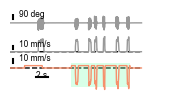

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(2,1), height_ratios=(1, 1, 2))

# data
ax[0].plot(t_b_v-5, tail_sum, color=(0.6, 0.6, 0.6)) # raw tail angles
ax[1].plot(t_s_v-5, f_v * max(vg), color=(0.6, 0.6, 0.6)) # fish velocity (swim effort)
ax[2].plot(t_s_v-5, totv, color=cc.cm.CET_D11(255)) # the stimulus velocity
ax[2].fill_between((8,18), (-40,-40), (10,10),  color=(0.5, 1.0, 0.7), alpha=0.3, zorder=-3)

# scale bars
put_scalebar(ax[0], -2, 90, 'deg')
put_scalebar(ax[1], -2, 10, 'mm/s')
put_scalebar(ax[2], -2, 10, 'mm/s')
put_scalebar(ax[2], -20, 2, 's', horizontal=True)

# clean up
for i, axx in enumerate(ax):
    if i>0:
        axx.plot(t_s_v-5, x*0, 'k--', zorder=-10)
    axx.set_axis_off()
    axx.set_xlim([-2.5,tps+11])
    
plt.savefig('./svgs/Fig1_indiv_fish.svg', format='svg')
plt.show()

## Fig. 1D (Fish-averaged time trace of instantaneous swim speed)

In [26]:
# separate trial averaged fish velocity into no wait / 5 s wait types
v_nowait = fvtrial_mean[:, :4, :, ]
v_5swait = fvtrial_mean[:, 4:, :, ]

# Calculate effect size (Cohen's d) between forward vs. backward for each fish, and then average
mean_diff = np.mean(fvtrial_mean[:, (3, 7), :] - fvtrial_mean[:, (0, 4), :], axis=0)
pooled_std_mean = np.sqrt(0.5*(np.var(fvtrial_mean[:, (3, 7), :], axis=0) + np.var(fvtrial_mean[:, (0, 4), :], axis=0)))
population_cohend = mean_diff / pooled_std_mean

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_12752\1311495088.py:8: RuntimeWarning: invalid value encountered in true_divide
  population_cohend = mean_diff / pooled_std_mean


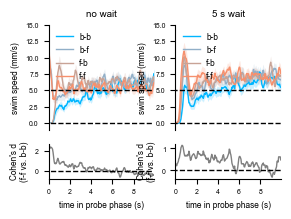

In [28]:
# Labels for priming direction combinations
label = ('b-b', 'b-f', 'f-b', 'f-f')

fig, ax= plt.subplots(2,2, figsize=(3,2), height_ratios=(3,1))
for i in range(4):
    plot_mean_sem(ax[0, 0], binned_t-8, v_nowait[:, i, :], color=cc.cm.CET_D11(i/3), label=label[i], lw=1)
for i in range(4):
    plot_mean_sem(ax[0, 1], binned_t-13, v_5swait[:, i, :], color=cc.cm.CET_D11(i/3), label=label[i], lw=1)

ax[0, 0].set_title('no wait')
ax[0, 1].set_title('5 s wait')

ax[1, 0].plot(binned_t-8, population_cohend[0, :], color=(0.5,0.5,0.5), lw=1)
ax[1, 1].plot(binned_t-13, population_cohend[1, :], color=(0.5,0.5,0.5), lw=1)


for axx in ax:
    for axxx in axx:
        axxx.set_xlim([0, 9.95])

for axx in ax[0]:
    axx.set_ylim([-1,15])
    axx.plot(binned_t-8, 5 + 0*(binned_t-8), 'k--')
    axx.plot(binned_t-8, 0*(binned_t-8), 'k--')
    axx.set_ylabel('swim speed (mm/s)')
    toggle_spines(axx, 0, 0, 0, 1)
    axx.legend(frameon=False)
    
for axx in ax[1]:
    axx.plot(binned_t-8, 0*(binned_t-8), 'k--')
    axx.set_ylabel('Cohen\'s d\n(f-f vs. b-b)')
    axx.set_xlabel('time in probe phase (s)')
    toggle_spines(axx, 0, 1, 0, 1)

plt.savefig('./svgs/Fig1_population_speed.svg', format='svg')
plt.show()

## Fig. S1A (Displacement visualization)

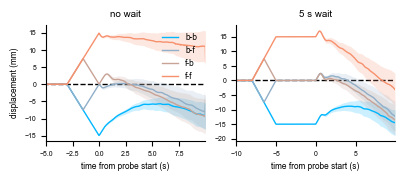

In [29]:
fig, ax= plt.subplots(1, 2, figsize=(4.5,1.5))
for i in range(4):
    plot_mean_sem(ax[0], binned_t-8, trial_mean[:, i, :], color=cc.cm.CET_D11(i/3), label=label[i], lw=1)
    plot_mean_sem(ax[1], binned_t-13, trial_mean[:, i+4, :], color=cc.cm.CET_D11(i/3), label=label[i], lw=1)
    
for axx in ax:
    axx.plot([-15,15],[0,0],'k--',zorder=-10)
    axx.set_xlabel('time from probe start (s)')
    toggle_spines(axx, 0, 1, 0, 1)

ax[0].set_title('no wait')
ax[1].set_title('5 s wait')

ax[0].set_ylabel('displacement (mm)')
ax[0].set_xlim([-5,9.9])
ax[1].set_xlim([-10,9.9])
ax[0].legend()

plt.savefig('./svgs/FigS1_population_displacement.svg', format='svg')
plt.show()